This is a version of the `solution-base` notebook that allows for iterating automatically through multiple settings based on the values in an Excel spreadsheet.

It is recommended that you fully understand `solution-base` before implementing this automated version.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import cs7641assn4 as a4
import numpy as np
import pandas as pd
import warnings
import xlrd
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns; sns.set()
pd.set_option('expand_frame_repr', True)
pd.set_option("display.max_rows", 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)




In [23]:
MAPS = {
    "4x4": [
        "SFFF",
        "FFFF",
        "FFFF",
        "HFHG"
    ], 
    "8x8" : [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHHHFF",
        "FFFHGHFF",
        "FFFHHHFF",
        "FFFFFFFF", 
        "FFFFFFFF",
        "FFFFFFFF"
    ],
    "20x20" : [
        "FHFFFHFFFFFFFHHFFFHF",
        "FHFFFFHFHHFFFHFFFHHH",
        "HHFFFFFFFHFFFFHFFFFH",
        "HFHFHFFFFFFHFHFFFHFF",
        "HHFFFFFHFFHHHFFFFFFF",
        "HFFHFHFFFFFFHHFFFFFF",
        "FHFFFFFFFHFFHFFFFFHF",
        "FFHHFFHHFFFHFFFHFHHF",
        "FFHHFFHFFFHHFFFHFFFH",
        "FFFFFFHFHHFFFHFFFFFH",
        "FFFHFHHFFHFFFFFHFFFF",
        "FFHFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFHFFFFFFHHF",
        "FFFHFHFFFFHFFFFFFFFF",
        "FFFHFHFFFFFFFFFFFFFF",
        "FFHHHFFFHFFFFFFFFFFF",
        "HHFHFFHFHHFFHFFFFFFF",
        "FFHFFFFFFFFFFFFFFFFF",
        "FFFFFFFFFHFFHFFFFFFG"
    ]
}

def plot_convergence(vi_epochs, pi_epochs, q_epochs):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 10))
    ax1.plot(vi_epochs['time'], vi_epochs['delta'], label='vi')
    ax1.plot(pi_epochs['time'], pi_epochs['delta'], label='pi')
    ax1.set_ylabel('V_sum')
    ax1.set_xlabel('time')
    ax1.legend()
    
    ax3.plot(q_epochs['time'], q_epochs['max_q'], label='q')
    ax3.set_ylabel('Q_max')
    ax3.set_xlabel('time')
    ax3.legend()
    
    ax2.plot(vi_epochs.index, vi_epochs['delta'], label='vi')
    ax2.plot(pi_epochs.index, pi_epochs['delta'], label='pi')
    ax2.set_ylabel('V_sum')
    ax2.set_xlabel('epoch')
    ax2.legend()

    ax4.plot(q_epochs.index, q_epochs['max_q'], label='q')
    ax4.set_ylabel('Q_max')
    ax4.set_xlabel('epoch')
    ax4.legend()
    
# Value Iteration
def perform_value_iteration(env, opt, print_arrows=True):    
    vi_V, vi_epochs = a4.valueIteration(env, opt['epsilon'], opt['gamma'], opt['max_iter'], report=opt['report'])

    vi_policy = a4.value_to_policy(env, V=vi_V, gamma=opt['gamma'])
    
    if print_arrows:
        vi_policy_arrows = a4.print_policy(vi_policy, width=opt['size'], height=opt['size'])

    if opt['display_print'] and print_arrows:
        # display value function:
        print('\n--Value Iteration Values in grid order--')
        a4.matprint(a4.print_value(vi_V, width=opt['size'], height=opt['size']))
        
        # display policy
        print('\n--Value Iteration Policy Matrix--')
        a4.matprint(vi_policy_arrows)
    return vi_V, vi_epochs, vi_policy, vi_policy_arrows
        
# Policy Iteration
def perform_policy_iteration(env, opt):
    pi_V, pi_policy, pi_epochs = a4.policy_iteration(env, opt['epsilon'], opt['gamma'], opt['max_iter'], report=opt['report'])
    
    pi_policy_arrows = a4.print_policy(pi_policy, width=opt['size'], height=opt['size'])

    if opt['display_print']:
        # Display values
        print('\n--Policy Iteration Values in grid order--')
        a4.matprint(a4.print_value(pi_V, width=opt['size'], height=opt['size']))

        # Display policy
        print('\n--Policy Iteration Policy Matrix--')
        a4.matprint(pi_policy_arrows)
    return pi_V, pi_epochs, pi_policy, pi_policy_arrows
        
# Q Learning
def perform_q_learning(env, opt):     
    Q, Q_epochs = a4.Qlearning(env, opt['qepsilon'], opt['lr'], opt['qgamma'], opt['max_iter'], opt['episodes'], 
                                     opt['initial'], opt['decay'], report=opt['report'])
    
#     plot_convergence(Q_epochs, opt, 'q')

    maxQ = np.max(Q,axis=1)

    Q_policy = a4.Q_to_policy(Q)

    Q_policy_arrows = a4.print_policy(Q_policy, width=opt['size'], height=opt['size'])

    if opt['display_print']: 
#         print('--Q with all options--')
#         a4.matprint(Q)
        print('\n--argmax(Q) in grid order--')
        a4.matprint(a4.print_value(maxQ, width=opt['size'], height=opt['size']))
        print('\n--Q-Learning Policy Matrix--')
        a4.matprint(Q_policy_arrows)
    return Q, Q_epochs, maxQ, Q_policy, Q_policy_arrows 

# Create Environment
def create_env(opt):

    map_name = 'x'.join([str(opt['size'])]*2) # None, if you want a random map
    print(map_name)
    
    
    env = a4.getEnv(env_id='hw4-FrozenLake-v0', rH=opt['rH'], rG=opt['rG'], rF=opt['rF'], 
                    size=opt['size'],  
                    is_slippery=opt['is_slippery'], render_initial=opt['render_initial'],
                    desc=MAPS[map_name])

    # Store a representation of the map
    env_desc = env.desc.astype('<U8')

    # Store a representation of the state rewards
    env_rs = a4.getStateReward(env)

    if opt['display_print']:
        # Display reward at each state
        print('\n--Reward Values at Each State--')
        a4.matprint(a4.print_value(env_rs, width=opt['size'], height=opt['size']))
    return env, env_desc, env_rs

def heat(arrows, values, size, ax, title):
    sns.heatmap(values.reshape(size,size), annot=arrows.reshape(size,size), linewidths=.5, fmt='', ax=ax).set_title(title)
    
    
    

In [8]:
settings = None
settings = pd.read_excel('default_settings.xlsx')
settings

,run,rH,rG,rF,size,p,is_slippery,render_initial,epsilon,gamma,max_iter,qepsilon,lr,qgamma,episodes,initial,decay,report,display_print,enabled
0,1,-1,1,-0.1,4,0.8,False,True,1.000000e-08,0.8,100,1,0.8,0.95,250,0,True,True,True,False
1,2,-1,1,-0.1,4,0.8,True,True,1.000000e-08,0.8,100,1,0.8,0.95,250,0,True,True,True,False
2,3,-1,5,-0.1,4,0.8,True,True,1.000000e-08,0.9,100,1,0.8,0.95,500,0,True,True,True,False
3,4,-1,500,-0.1,20,0.8,False,True,1.000000e-08,0.8,1000,1,0.8,0.80,1000,0,True,True,True,False
4,5,-1,5000,-0.1,20,0.8,True,True,1.000000e-08,0.8,1000,1,0.8,0.80,1000,0,True,True,True,False
5,6,-1,500,-0.1,8,0.8,True,True,1.000000e-08,0.8,100,1,0.8,0.80,100,0,True,True,True,True


4x4
--Board--

SFFF
FFFF
FFFF
HFHG

--Actions for Position to the Left of the Goal--
{0: [(1.0, 14, -1, True)],
 1: [(1.0, 14, -1, True)],
 2: [(1.0, 14, -1, True)],
 3: [(1.0, 14, -1, True)]}

--Reward Values at Each State--
-0.1  -0.1  -0.1  -0.1  
-0.1  -0.1  -0.1  -0.1  
-0.1  -0.1  -0.1  -0.1  
  -1  -0.1    -1     1  
Value iteration converged after  91 epochs

--Value Iteration Values in grid order--
1.3022  1.7528  2.316  3.02  
1.7528   2.316   3.02   3.9  
 2.316    3.02    3.9     5  
    -5   2.316     -5     5  

--Value Iteration Policy Matrix--
↓  ↓  ↓  ↓  
↓  ↓  ↓  ↓  
→  →  →  ↓  
←  ↑  ←  ←  
Policy iteration converged after  5 epochs

--Policy Iteration Values in grid order--
1.3022  1.7528  2.316  3.02  
1.7528   2.316   3.02   3.9  
 2.316    3.02    3.9     5  
    -5   2.316     -5     5  

--Policy Iteration Policy Matrix--
↓  ↓  ↓  ↓  
↓  ↓  ↓  ↓  
→  →  →  ↓  
←  ↑  ←  ←  

--argmax(Q) in grid order--
1.0564  1.2173  1.3866  1.5649  
1.2173  1.3866  1.5649  1.

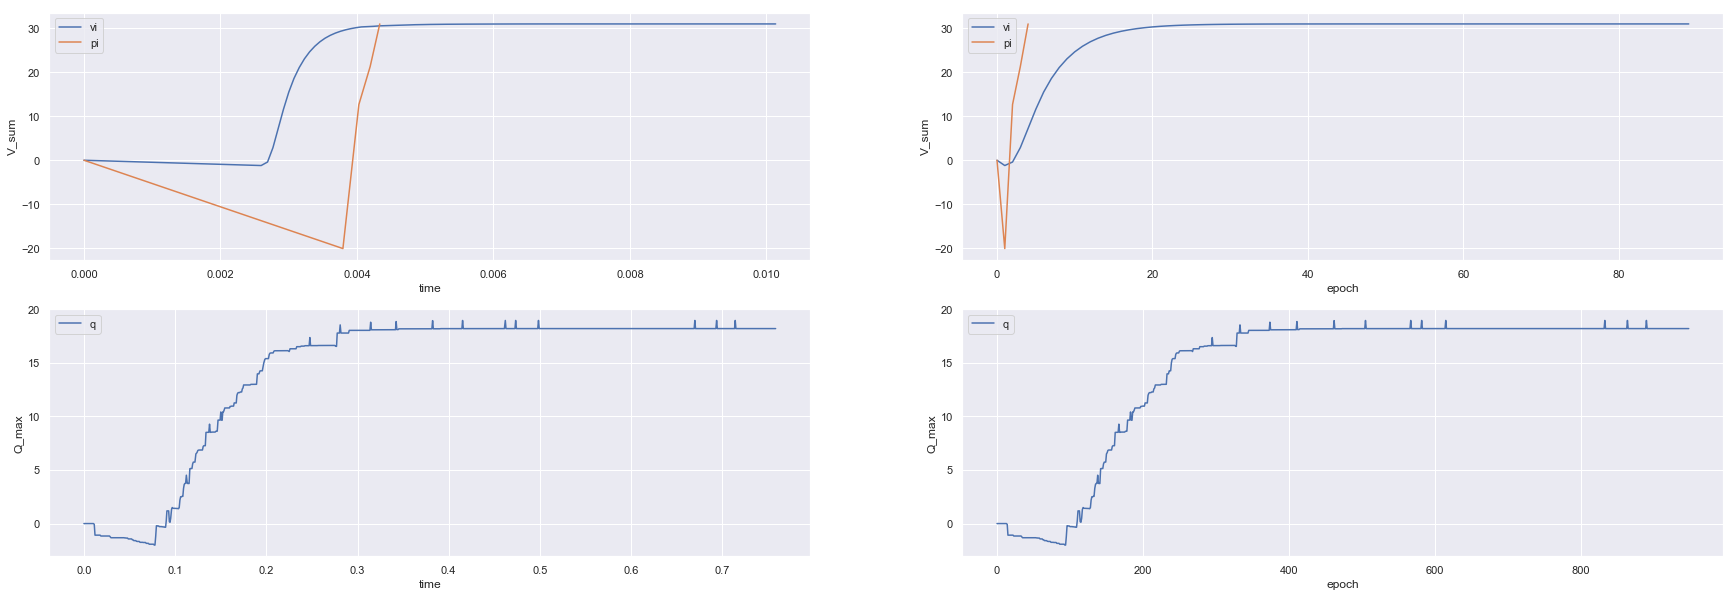

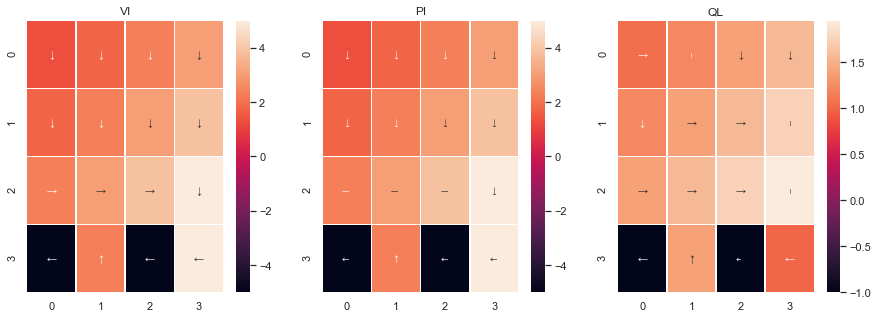

In [26]:


# Import settings, uncomment to read settings from an excel spreadsheet
settings = pd.read_excel('default_settings.xlsx')
settings
results = None
for i, opt in settings.iterrows():
    if not opt['enabled']: continue
    
    env, env_desc, env_rs = create_env(opt)
    vi_V, vi_epochs, vi_policy, vi_policy_arrows = perform_value_iteration(env, opt)
    pi_V, pi_epochs, pi_policy, pi_policy_arrows = perform_policy_iteration(env, opt)
    Q, Q_epochs, maxQ, Q_policy, Q_policy_arrows  = perform_q_learning(env, opt)
    plot_convergence(vi_epochs, pi_epochs, Q_epochs)
#     plt.figure()
    f,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))
    heat(vi_policy_arrows, vi_V, opt['size'], ax1, 'VI')
    heat(pi_policy_arrows, pi_V, opt['size'], ax2, 'PI')
    heat(Q_policy_arrows, maxQ, opt['size'], ax3, 'QL')
    


# Notes


In [22]:
print(Q_epochs.groupby(['episode'])['iteration'].max().describe())


count    500.000000
mean      57.000000
std       34.290343
min        0.000000
25%       28.000000
50%       56.000000
75%       99.000000
max       99.000000
Name: iteration, dtype: float64


Default rewards in OpenAI gym Frozen-Lake-v0 are 1 for the G(oal) and 0 for everything else.

Maps are drawn according to the following logic

```
if desc and map_name are None, 
   then a default random map is drawn with 8
        using frozen_lake.generate_random_map(size=8, p=0.8)
elif desc is None and a map_name is given
   then a map_name is either '4x4' or '8x8'
        and is drawn from the dict MAPS in frozen_lake.py
elif desc is given
   then it must be in the form of a list with 
```

Default action probabilities are 1/3 chosen action, 1/3 each for right angles to chosen action, and 0 for reverse of chosen action. This is set with `is_slippery=True`. If `is_slippery=False`, then P=1 for chosen action and 0 for all other actions.

|ACTION|Value|Symbol|
|------|-----|------|
|LEFT  | 0   | ←    |
|DOWN  | 1   | ↓    |
|RIGHT | 2   | →    |
|UP    | 3   | ↑    |

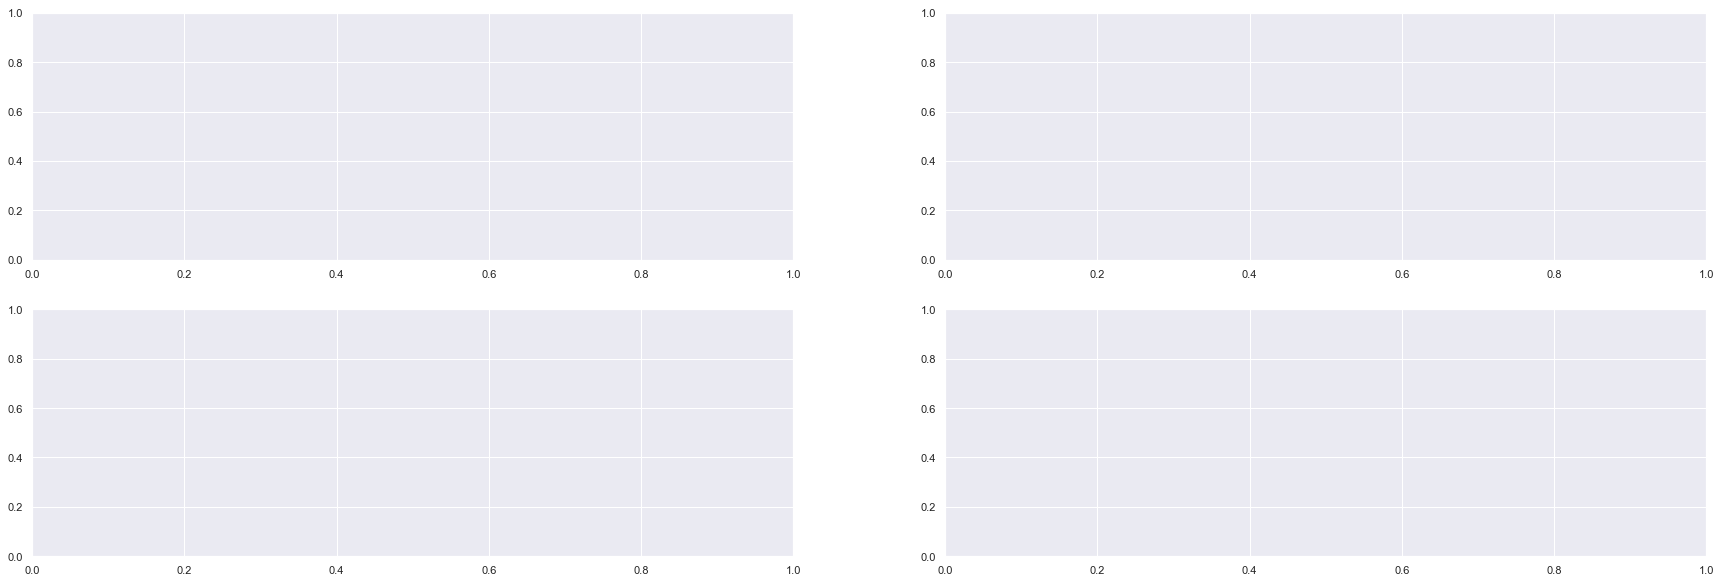

In [4]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 10))





# Sources

- Environment: <https://gym.openai.com/envs/FrozenLake-v0/>
- Code: <https://github.com/Twice22/HandsOnRL>
- Tutorial: <https://twice22.github.io/>